<a href="https://colab.research.google.com/github/JMaio/pdiot-har-project/blob/main/tensorflow/pdiot_training_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
print(f"TF version: {tf.__version__}")

%matplotlib notebook

TF version: 2.3.0


In [2]:
import os
from pathlib import Path
import re

In [3]:
data_root = Path('.')/'data'
!git clone https://github.com/specknet/pdiot-data.git $data_root

Cloning into 'data'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 1537 (delta 6), reused 129 (delta 4), pack-reused 1406
Receiving objects: 100% (1537/1537), 24.69 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [4]:
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1616573': 94,
 's1621503': 84,
 's1642301': 84,
 's1655560': 78,
 's1660711': 36,
 's1701688': 84,
 's1704037': 80,
 's1710228': 78,
 's1711507': 97,
 's1721039': 81,
 's1737472': 78,
 's1746788': 84,
 's1758009': 78,
 's1764751': 20,
 's2017768': 8}

In [5]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

In [6]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = int(self.act_code)


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [7]:
def plot_respeck_fig(df):
  fig = plt.figure(figsize=(10, 8))
  plt.plot(df['accel_x'], label="accel_x")
  plt.plot(df['accel_y'], label="accel_y")
  plt.plot(df['accel_z'], label="accel_z")
  plt.legend()
  return plt

In [8]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Wrist', sensor_side='Right', act_type='Standing', act_code=100, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601826599942    0 -1.002930 -0.389954  0.172302
1    1601826600020    1 -0.981445 -0.409729  0.156189
2    1601826600099    2 -0.997559 -0.392395  0.188416
3    1601826600178    3 -1.035645 -0.338440  0.209167
4    1601826600257    4 -0.980225 -0.330139  0.184021
..             ...  ...       ...       ...       ...
411  1601826633381  411 -0.964600 -0.377502  0.111755
412  1601826633460  412 -0.967285 -0.386780  0.113708
413  1601826633538  413 -0.964844 -0.381409  0.109314
414  1601826633617  414 -0.968262 -0.373108  0.111755
415  1601826633696  415 -0.964111 -0.379700  0.109314

[416 rows x 5 columns])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

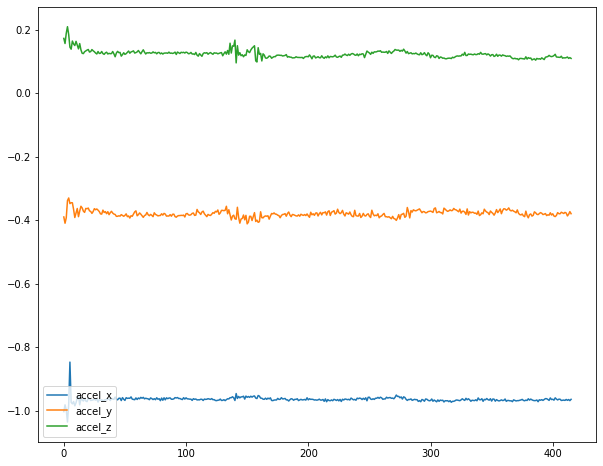

In [9]:
plot_respeck_fig(act.df)

In [10]:
train = read_custom_file(files["s1621503"][0])
test  = read_custom_file(files["s1616573"][0])

In [11]:
keys = ["accel_x", "accel_y", "accel_z"]

In [12]:
train_data = np.array([train.df.iloc[0].get(keys).values])
train_code = train.header.act_code
test_data = np.array([test.df.iloc[0].get(keys).values])
test_code = test.header.act_code

In [13]:
train_data, train_code

(array([[-1.0029297 , -0.3899536 ,  0.17230225]]), 100)

In [14]:
test_data, test_code

(array([[0.51342773, 0.02947998, 0.77020264]]), 7)

In [15]:
model = tf.keras.models.Sequential([
  # tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(14, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, np.array([ACTIVITY_CODE_TO_TFCODE_MAPPING[train_code]]), epochs=1)

1/1 [==============================] - 0s 1ms/step - loss: 2.3982 - accuracy: 1.0000


In [16]:
np.argmax(model.predict(test_data), axis=-1)

array([2])

In [17]:
model.evaluate(test_data, np.array([ACTIVITY_CODE_TO_TFCODE_MAPPING[test_code]]))

1/1 [==============================] - 0s 1ms/step - loss: 2.6751 - accuracy: 0.0000e+00


[2.6750802993774414, 0.0]

In [18]:
# https://www.tensorflow.org/lite/convert/index#convert_a_keras_model_
# (to generate a SavedModel) tf.saved_model.save(model, "saved_model_keras_dir")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpn1cmbyvv/assets
